In [1]:
%matplotlib widget

# 1) Single line fitting

In this example, we perform single line fitting on the spectrum of the Green Pea galaxy GP121903 which was observed
with the GTC (Gran Telescopio de Canarias). You can download this spectrum from the [examples/sample_data](https://github.com/Vital-Fernandez/lime/tree/master/examples/sample_data). You can read more about these observations in [Fernandez et al (2021)](https://arxiv.org/abs/2110.07741).

This tutorial can found as a script and a notebook on the [examples folder](https://github.com/Vital-Fernandez/lime/tree/master/examples/tutorials).

## Loading the spectrum data

We start by importing the programing packages necessary to run the script, including $LiMe$.

In [2]:
import numpy as np
from astropy.io import fits
import lime

In [3]:
lime.theme.set_style(fig_conf={"figure.dpi": 100})

The following functions reads a *.fits* from the *ISIS* instrument and returns the wavelength and flux arrays along with the data extension header. 

In [4]:
def import_osiris_fits(file_address, ext=0):

    # Open the fits file
    with fits.open(file_address) as hdul:
        data, header = hdul[ext].data, hdul[ext].header

    # Reconstruct the wavelength array from the header data
    w_min, dw, n_pix = header['CRVAL1'],  header['CD1_1'], header['NAXIS1']
    w_max = w_min + dw * n_pix
    wavelength = np.linspace(w_min, w_max, n_pix, endpoint=False)

    return wavelength, data, header

Now we can declare the data location and load it: 

In [5]:
# Address of the Green Pea galaxy spectrum
fits_file = '../sample_data/spectra/gp121903_osiris.fits'

# Load spectrum
wave, flux, hdr = import_osiris_fits(fits_file)

We provide the galaxy redshift and a normalization constant for the spectrum:

In [6]:
# Galaxy redshift and the flux normalization
z_obj = 0.19531
normFlux = 1e-18

$LiMe$ will automatically normalize the observation flux if the mean value is well below the unity $F_{mean} < 0.01$. But is is recomended that the user provides a value. 

We now have all the data to define a spectrum:

In [7]:
# Define a spectrum object
gp_spec = lime.Spectrum(wave, flux, redshift=z_obj, norm_flux=normFlux)

We can plot the spectrum with the following command

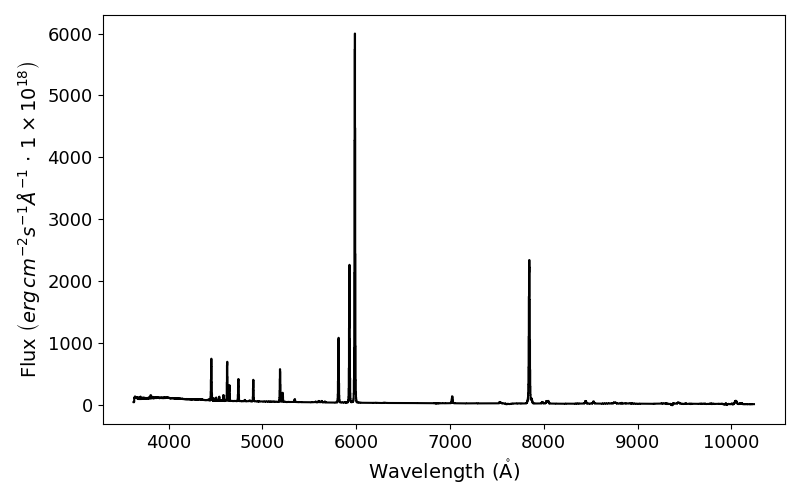

In [8]:
gp_spec.plot.spectrum(label='GP121903')

## Perform the fittings

To measure lines you use the functions from the `fit` attribute. For example, in the case of a single line, you would use the ``fit.band``. For example, to measure of $H\alpha$ you can use:

In [9]:
gp_spec.fit.bands(6563)

To plot the lattest fitting you can run:

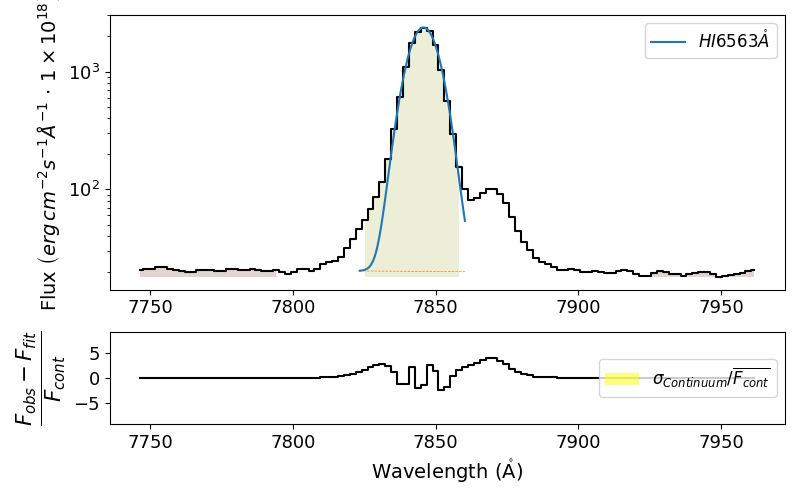

In [10]:
gp_spec.plot.bands()

It is recommended, however, that the user employs $LiMe$ label notation. The user can also provide his/her bands: 

In [11]:
# Line name and its location mask in the rest _frame
line = 'H1_6563A'
band_edges = np.array([6438.03, 6508.66, 6535.10, 6600.95, 6627.70, 6661.82])

We repeat now the fitting:

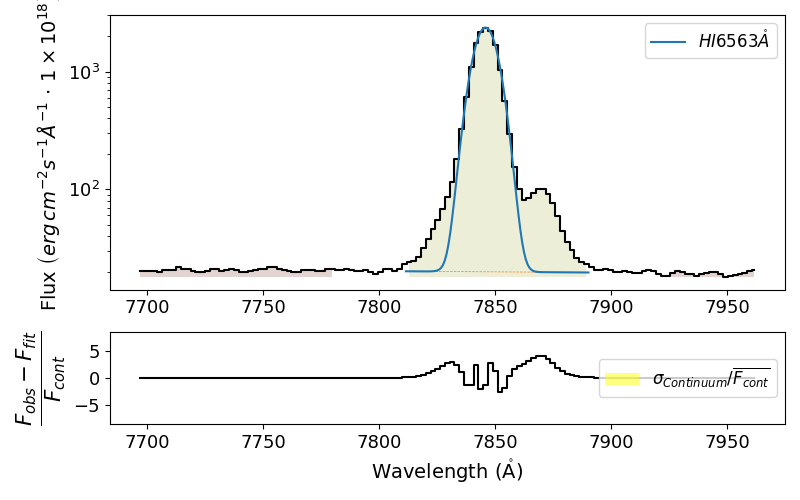

In [12]:
# Run the fitting and plot it
gp_spec.fit.bands(line, band_edges)
gp_spec.plot.bands()

You can see that the result was not very good. Let’s increase the complexity by including the $[NII]$ doublet:

In [13]:
# Fit configuration
line = 'H1_6563A_b'
fit_conf = {'H1_6563A_b': 'H1_6563A+N2_6584A+N2_6548A',
            'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'},
            'N2_6548A_kinem': 'N2_6584A'}

In the dictionary above, we have three elements:
- The *H1_6563A_b* line has three components: *H1_6563A*, *N2_6584A* and *N2_6548A*.
- The *N2_6548A* line has an amplitude fixed by a factor of the *N2_6584A* line amplitude.
- The *N2_6548A* line has its kinematics (both radial and dispersion velocity) tied to those of *N2_6584A*.

We repeat the fitting including this configuration:

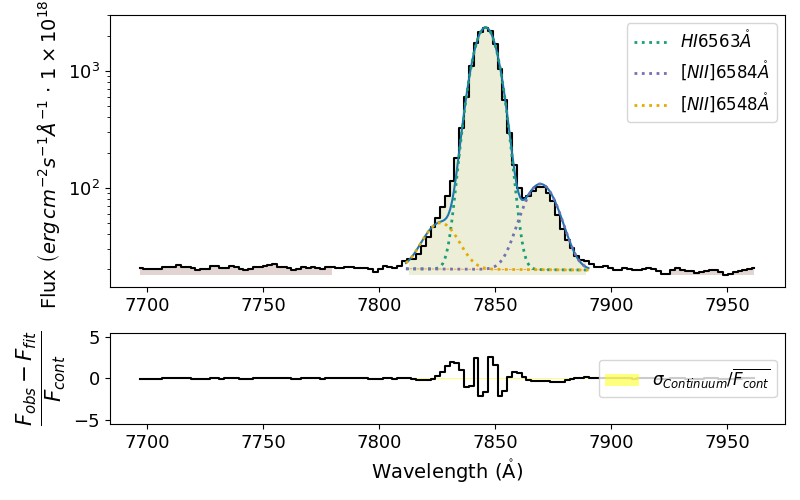

In [14]:
# New attempt including the fit configuration
gp_spec.fit.bands(line, band_edges, fit_conf=fit_conf)
gp_spec.plot.bands()

Since, we didnt introduce a line on the ``Spectrum.plot.bands`` function, it will display the one from the last measurement

<div class="alert alert-info">

**Please remember:** To declare a multi-Gaussian fitting, two conditions are necessary. The line label must have the **_b**  suffix *(H1_6563A_b)* and the line components must be specified in the **fit_conf** dictionary *(H1_6563A-N2_6584A-N2_6548A)*.

</div>

## Save the results

You can store a plot into an image file by adding an output address:

In [15]:
# You can also save the fitting plot to a file
gp_spec.plot.bands(output_address=f'../sample_data/{line}.png')

The measurements are stored as a [pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) into the spectrum ``frame`` atribute:

In [16]:
# Each fit is stored in the lines dataframe (log) attribute
gp_spec.frame

,wavelength,intg_flux,intg_flux_err,profile_flux,profile_flux_err,eqw,eqw_err,particle,latex_label,group_label,...,v_10,v_90,v_95,v_99,chisqr,redchi,aic,bic,observations,comments
H1_6563A,6563.0,3.128658e-14,8.469290e-18,2.918072e-14,1.627870e-16,1464.877847,48.552997,H1,$HI6563\mathring{A}$,H1_6563A+N2_6584A+N2_6548A,...,-304.860118,254.175982,427.746053,1043.985256,42306.907359,440.696952,626.828749,642.578586,no,no
N2_6584A,6584.0,3.128658e-14,8.469290e-18,1.468287e-15,1.802704e-16,73.708323,9.364551,N2,$[NII]6584\mathring{A}$,H1_6563A+N2_6584A+N2_6548A,...,-304.860118,254.175982,427.746053,1043.985256,42306.907359,440.696952,626.828749,642.578586,no,no
N2_6548A,6548.0,3.128658e-14,8.469290e-18,4.981081e-16,6.049065e-17,25.005126,3.144619,N2,$[NII]6548\mathring{A}$,H1_6563A+N2_6584A+N2_6548A,...,-304.860118,254.175982,427.746053,1043.985256,42306.907359,440.696952,626.828749,642.578586,no,no


This log can be saved into a file using the ``save_frame`` attribute. The extention specifies the file type. You can also constrain the output measurements in addition to file sheet (only for multi-page file types) 

In [17]:
# It can be saved into different types of document using the function
gp_spec.save_frame('../sample_data/example1_linelog.txt')
gp_spec.save_frame('../sample_data/example1_linelog.pdf', param_list=['eqw', 'intg_flux', 'intg_flux_err', 'profile_flux', 'profile_flux_err'])
gp_spec.save_frame('../sample_data/example1_linelog.fits', page='GP121903')
gp_spec.save_frame('../sample_data/example1_linelog.xlsx', page='GP121903')
gp_spec.save_frame('../sample_data/example1_linelog.asdf', page='GP121903')

/home/vital/PycharmProjects/lime/venv/lib/python3.11/site-packages/asdf/yamlutil.py:282: AsdfConversionWarning: A ndarray subclass (<class 'numpy.recarray'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(


A lines dataframe can also be saved/loaded calling the ``lime.save_frame``/``lime.load_frame`` function:

In [18]:
log_address = '../sample_data/example1_linelog.fits'
lime.save_frame(log_address, gp_spec.frame, page='GP121903')
log = lime.load_frame(log_address, page='GP121903')